In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from itertools import chain 
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import torch.optim as optim

#### Loading data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

In [3]:
#train data
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
#test data
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)


In [4]:
# preparing data to split validation
train_Size = len(train_set)
index_train= list(range(train_Size))
np.random.shuffle(index_train)
# split 0.2 % of trainset to validation
split= int(np.floor(train_Size*0.8))
trainset= SubsetRandomSampler(index_train[:split])
validationset= SubsetRandomSampler(index_train[split:])

In [5]:
batch_size = 128
train_loader = DataLoader(train_set, sampler=trainset, batch_size=batch_size,
                                           num_workers=2)
validation_loader = DataLoader(train_set, sampler= validationset, batch_size=batch_size,
                                           num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size,
                                         shuffle= True, num_workers=2)

In [6]:
print('number of train data:', len(trainset))
print('number of validation data:', len(validationset))
print('number of test data:',len(testset))

number of train data: 48000
number of validation data: 12000
number of test data: 10000


In [7]:
# classes of data
classes = ('T_shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandals', 'Shirt', 'Sneaker', 'Bag', 'Ankle boots')

##### Display some datas and their classes

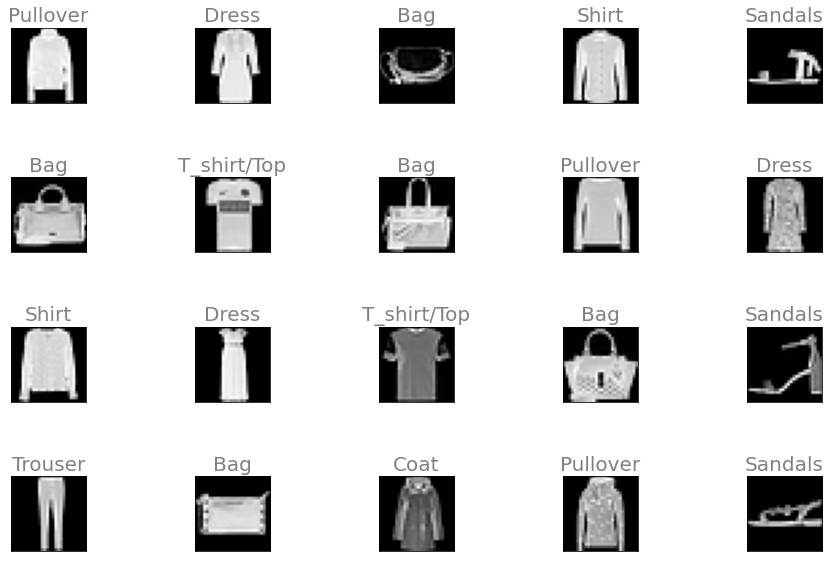

In [8]:
images, labels= next(iter(train_loader))
fig = plt.figure(figsize= (15,9))
for index in np.arange(20):
    ax= fig.add_subplot(4, 5 , index+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[index]), cmap= 'gray')
    
    ax.set_title(classes[labels[index].item()], color='gray', fontsize=20)
    fig.tight_layout(pad=5)
    

## First Architecture: architecture2

In [9]:
#architecture2
class NET_arc2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1= nn.Conv2d(1,64,2)
        # self.norm_2d = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2)
        self.drop = nn.Dropout(0.25)
        self.conv2= nn.Conv2d(64,64,2)
        self.fc1= nn.Linear(9216,64)
        self.fc2= nn.Linear(64,10)
        
        ####################   Weight Initialization  #####################
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        # x = self.norm_2d(x)
        x= self.pool(x)
        x= self.drop(x)
        
        x = F.relu(self.conv2(x))
        x = self.drop(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x= self.drop(x)
        
        x = F.softmax(self.fc2(x), dim=1)
        
        return x
        

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### State 1 of first architecture: Adam Optimizer

In [11]:
net_arc2= NET_arc2().to(device)

##### Loss Function:

In [12]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()


##### Optimizer:

In [13]:
learning_rate = 0.001
optimizer = torch.optim.Adam(net_arc2.parameters(), lr=learning_rate)

##### Training:

In [14]:
net_arc2.to(device)
epochs = 50

loss_train_list,loss_test_list = [] , []
train_accuracy_list, test_accuracy_list = [], []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

###################################    Training     ##########################################
for epoch in range(1, epochs+1):
    total_train, total_test = 0 , 0
    correct_train, correct_test = 0 , 0


    sum_of_loss_train = 0
    net_arc2.train()
    # Loop for train batches
    loop_train = tqdm(enumerate(train_loader, 1),total=len(train_loader), desc="train")
    for i,(inputs, labels) in loop_train:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net_arc2(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #calculate loss of train data
        sum_of_loss_train += loss.item()
        loop_train.set_description(f'Train - epoch : {epoch}')
        loop_train.set_postfix(current_loss = {sum_of_loss_train/i})
        loop_train.refresh()
        #calculate accuracy of train data
        predictions_train = torch.max(outputs, 1)[1].to(device)
        correct_train += (predictions_train == labels).sum()
        total_train += len(labels)
        
    train_accuracy = correct_train * 100 / total_train   
    train_accuracy_list.append(train_accuracy.cpu()) 
                
    loss_train_list.append((sum_of_loss_train/i))

    net_arc2.to(device)
    ################################    Testing by validation data    ##############################################
    net_arc2.eval()
    with torch.no_grad():
    # Loop for test batches
        loop_test = tqdm(enumerate(validation_loader, 1),total=len(validation_loader), desc="val")
        sum_of_loss_test = 0
        for i,(inputs, labels) in loop_test:
            inputs, labels = inputs.to(device), labels.to(device)
            labels_list.append(labels)
            outputs = net_arc2(inputs)
            #calculate loss of test data
            curr_loss_test = criterion(outputs, labels)
            sum_of_loss_test += curr_loss_test.item()
            loop_test.set_description(f'Test - epoch : {epoch}')
            loop_test.set_postfix(curr_loss_test = {sum_of_loss_test/i})   
            loop_test.refresh()
            #calculate accuracy of test data
            predictions_test = torch.max(outputs, 1)[1].to(device)
            predictions_list.append(predictions_test)
            correct_test += (predictions_test == labels).sum()
            total_test += len(labels)
            
        test_accuracy = correct_test * 100 / total_test
        test_accuracy_list.append(test_accuracy.cpu())             
        
        loss_test_list.append((sum_of_loss_test/i))
            
            
            
        print(f'At Epoch {epoch}/{epochs}:  Train Loss= {loss_train_list[-1]} , Train Accuracy= {train_accuracy:.3f} %')
        print(f'At Epoch {epoch}/{epochs}: Test Loss= {loss_test_list[-1]} , Test Accuracy= {test_accuracy:.3f} %')

Test - epoch : 1: 100%|██████████| 94/94 [00:05<00:00, 15.68it/s, curr_loss_test={1.6536214668700036}]


At Epoch 1/50:  Train Loss= 1.7480588207244874 , Train Accuracy= 71.435 %
At Epoch 1/50: Test Loss= 1.6536214668700036 , Test Accuracy= 80.800 %


Test - epoch : 2: 100%|██████████| 94/94 [00:06<00:00, 13.96it/s, curr_loss_test={1.6440598698372537}]


At Epoch 2/50:  Train Loss= 1.6549119621912638 , Train Accuracy= 80.675 %
At Epoch 2/50: Test Loss= 1.6440598698372537 , Test Accuracy= 81.825 %


Test - epoch : 3: 100%|██████████| 94/94 [00:06<00:00, 15.08it/s, curr_loss_test={1.6353492051997083}]


At Epoch 3/50:  Train Loss= 1.6457752103805543 , Train Accuracy= 81.590 %
At Epoch 3/50: Test Loss= 1.6353492051997083 , Test Accuracy= 82.575 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 4/50:  Train Loss= 1.6397629928588868 , Train Accuracy= 82.127 %
At Epoch 4/50: Test Loss= 1.6290169649935784 , Test Accuracy= 83.117 %


Test - epoch : 5: 100%|██████████| 94/94 [00:05<00:00, 15.69it/s, curr_loss_test={1.6351126736782966}]


At Epoch 5/50:  Train Loss= 1.6364891821543375 , Train Accuracy= 82.438 %
At Epoch 5/50: Test Loss= 1.6351126736782966 , Test Accuracy= 82.508 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 6/50:  Train Loss= 1.6337938324610393 , Train Accuracy= 82.731 %
At Epoch 6/50: Test Loss= 1.6277452605835936 , Test Accuracy= 83.300 %


Test - epoch : 7: 100%|██████████| 94/94 [00:06<00:00, 15.40it/s, curr_loss_test={1.6258465837925038}]


At Epoch 7/50:  Train Loss= 1.6276709493001302 , Train Accuracy= 83.333 %
At Epoch 7/50: Test Loss= 1.6258465837925038 , Test Accuracy= 83.442 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 8/50:  Train Loss= 1.6120353816350301 , Train Accuracy= 84.871 %
At Epoch 8/50: Test Loss= 1.5918030802239762 , Test Accuracy= 87.033 %


Test - epoch : 9: 100%|██████████| 94/94 [00:06<00:00, 15.22it/s, curr_loss_test={1.5798228116745645}]


At Epoch 9/50:  Train Loss= 1.5949290459950765 , Train Accuracy= 86.600 %
At Epoch 9/50: Test Loss= 1.5798228116745645 , Test Accuracy= 88.042 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 10/50:  Train Loss= 1.5872671540578207 , Train Accuracy= 87.375 %
At Epoch 10/50: Test Loss= 1.5798992818974433 , Test Accuracy= 88.067 %


Test - epoch : 11: 100%|██████████| 94/94 [00:06<00:00, 14.55it/s, curr_loss_test={1.5756302158883277}]


At Epoch 11/50:  Train Loss= 1.5806327327092489 , Train Accuracy= 88.054 %
At Epoch 11/50: Test Loss= 1.5756302158883277 , Test Accuracy= 88.458 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 12/50:  Train Loss= 1.5759645058314005 , Train Accuracy= 88.515 %
At Epoch 12/50: Test Loss= 1.5675319927804015 , Test Accuracy= 89.325 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 13/50:  Train Loss= 1.5739457092285156 , Train Accuracy= 88.704 %
At Epoch 13/50: Test Loss= 1.5698803434980677 , Test Accuracy= 89.058 %


Test - epoch : 14: 100%|██████████| 94/94 [00:05<00:00, 16.39it/s, curr_loss_test={1.5670538519291168}]


At Epoch 14/50:  Train Loss= 1.5698816992441813 , Train Accuracy= 89.181 %
At Epoch 14/50: Test Loss= 1.5670538519291168 , Test Accuracy= 89.383 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 15/50:  Train Loss= 1.5676903460820515 , Train Accuracy= 89.360 %
At Epoch 15/50: Test Loss= 1.5646710839677365 , Test Accuracy= 89.608 %


Test - epoch : 16: 100%|██████████| 94/94 [00:04<00:00, 19.01it/s, curr_loss_test={1.5686453745720235}]


At Epoch 16/50:  Train Loss= 1.565713101387024 , Train Accuracy= 89.556 %
At Epoch 16/50: Test Loss= 1.5686453745720235 , Test Accuracy= 89.175 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 17/50:  Train Loss= 1.5618868805567423 , Train Accuracy= 89.904 %
At Epoch 17/50: Test Loss= 1.5671983285153166 , Test Accuracy= 89.342 %


Test - epoch : 18: 100%|██████████| 94/94 [00:05<00:00, 17.15it/s, curr_loss_test={1.5591787886112294}]


At Epoch 18/50:  Train Loss= 1.5604859968821208 , Train Accuracy= 90.104 %
At Epoch 18/50: Test Loss= 1.5591787886112294 , Test Accuracy= 90.133 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 19/50:  Train Loss= 1.557701981226603 , Train Accuracy= 90.365 %
At Epoch 19/50: Test Loss= 1.5601252520338018 , Test Accuracy= 90.083 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 20/50:  Train Loss= 1.556642786026001 , Train Accuracy= 90.450 %
At Epoch 20/50: Test Loss= 1.5549948710076353 , Test Accuracy= 90.625 %


Test - epoch : 21: 100%|██████████| 94/94 [00:07<00:00, 12.13it/s, curr_loss_test={1.5567439211175798}]


At Epoch 21/50:  Train Loss= 1.5554252262115478 , Train Accuracy= 90.594 %
At Epoch 21/50: Test Loss= 1.5567439211175798 , Test Accuracy= 90.458 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 22/50:  Train Loss= 1.5549979333877564 , Train Accuracy= 90.635 %
At Epoch 22/50: Test Loss= 1.5539363470483334 , Test Accuracy= 90.775 %


Test - epoch : 23: 100%|██████████| 94/94 [00:08<00:00, 11.14it/s, curr_loss_test={1.5539595751052206}]


At Epoch 23/50:  Train Loss= 1.5525158408482869 , Train Accuracy= 90.838 %
At Epoch 23/50: Test Loss= 1.5539595751052206 , Test Accuracy= 90.667 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 24/50:  Train Loss= 1.5513642406463624 , Train Accuracy= 90.987 %
At Epoch 24/50: Test Loss= 1.5543342892159806 , Test Accuracy= 90.608 %


Test - epoch : 25: 100%|██████████| 94/94 [00:04<00:00, 19.09it/s, curr_loss_test={1.552793118547886}] 


At Epoch 25/50:  Train Loss= 1.5485941022237142 , Train Accuracy= 91.273 %
At Epoch 25/50: Test Loss= 1.552793118547886 , Test Accuracy= 90.767 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 26/50:  Train Loss= 1.5475101563135782 , Train Accuracy= 91.406 %
At Epoch 26/50: Test Loss= 1.5519760644182246 , Test Accuracy= 90.892 %


Test - epoch : 27: 100%|██████████| 94/94 [00:05<00:00, 17.91it/s, curr_loss_test={1.5532836089742945}]


At Epoch 27/50:  Train Loss= 1.5467121264139811 , Train Accuracy= 91.502 %
At Epoch 27/50: Test Loss= 1.5532836089742945 , Test Accuracy= 90.758 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 28/50:  Train Loss= 1.5456682287851968 , Train Accuracy= 91.565 %
At Epoch 28/50: Test Loss= 1.5492905378341675 , Test Accuracy= 91.158 %


Test - epoch : 29: 100%|██████████| 94/94 [00:05<00:00, 15.68it/s, curr_loss_test={1.5523696541786194}]


At Epoch 29/50:  Train Loss= 1.5440687313079835 , Train Accuracy= 91.727 %
At Epoch 29/50: Test Loss= 1.5523696541786194 , Test Accuracy= 90.833 %


Test - epoch : 30: 100%|██████████| 94/94 [00:06<00:00, 15.57it/s, curr_loss_test={1.553572359237265}] 


At Epoch 30/50:  Train Loss= 1.5428217188517253 , Train Accuracy= 91.877 %
At Epoch 30/50: Test Loss= 1.553572359237265 , Test Accuracy= 90.692 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 31/50:  Train Loss= 1.5437462298075357 , Train Accuracy= 91.742 %
At Epoch 31/50: Test Loss= 1.5491259326326086 , Test Accuracy= 91.158 %


Test - epoch : 32: 100%|██████████| 94/94 [00:05<00:00, 17.52it/s, curr_loss_test={1.5504602282605273}]


At Epoch 32/50:  Train Loss= 1.5408841053644815 , Train Accuracy= 91.992 %
At Epoch 32/50: Test Loss= 1.5504602282605273 , Test Accuracy= 91.050 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 33/50:  Train Loss= 1.5401908931732178 , Train Accuracy= 92.119 %
At Epoch 33/50: Test Loss= 1.5502408958495932 , Test Accuracy= 91.025 %


Test - epoch : 34: 100%|██████████| 94/94 [00:06<00:00, 14.86it/s, curr_loss_test={1.5498885093851293}]


At Epoch 34/50:  Train Loss= 1.5387354494730632 , Train Accuracy= 92.281 %
At Epoch 34/50: Test Loss= 1.5498885093851293 , Test Accuracy= 91.083 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 35/50:  Train Loss= 1.5397750171025595 , Train Accuracy= 92.165 %
At Epoch 35/50: Test Loss= 1.5475654779596533 , Test Accuracy= 91.358 %


Test - epoch : 36: 100%|██████████| 94/94 [00:05<00:00, 18.04it/s, curr_loss_test={1.5476166542540206}]


At Epoch 36/50:  Train Loss= 1.538229996363322 , Train Accuracy= 92.308 %
At Epoch 36/50: Test Loss= 1.5476166542540206 , Test Accuracy= 91.250 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 37/50:  Train Loss= 1.5388506418863932 , Train Accuracy= 92.219 %
At Epoch 37/50: Test Loss= 1.5497148518866681 , Test Accuracy= 91.067 %


Test - epoch : 38: 100%|██████████| 94/94 [00:05<00:00, 18.29it/s, curr_loss_test={1.5489540480552835}]


At Epoch 38/50:  Train Loss= 1.536918786684672 , Train Accuracy= 92.417 %
At Epoch 38/50: Test Loss= 1.5489540480552835 , Test Accuracy= 91.192 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 39/50:  Train Loss= 1.5353996079762777 , Train Accuracy= 92.560 %
At Epoch 39/50: Test Loss= 1.5471590009141476 , Test Accuracy= 91.425 %


Test - epoch : 40: 100%|██████████| 94/94 [00:06<00:00, 14.43it/s, curr_loss_test={1.544971765355861}] 


At Epoch 40/50:  Train Loss= 1.5356231915156047 , Train Accuracy= 92.585 %
At Epoch 40/50: Test Loss= 1.544971765355861 , Test Accuracy= 91.575 %


Test - epoch : 41: 100%|██████████| 94/94 [00:05<00:00, 15.74it/s, curr_loss_test={1.5457398891448975}]


At Epoch 41/50:  Train Loss= 1.5350038000742594 , Train Accuracy= 92.590 %
At Epoch 41/50: Test Loss= 1.5457398891448975 , Test Accuracy= 91.517 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 42/50:  Train Loss= 1.5341841328938801 , Train Accuracy= 92.681 %
At Epoch 42/50: Test Loss= 1.544043097090214 , Test Accuracy= 91.633 %


Test - epoch : 43: 100%|██████████| 94/94 [00:05<00:00, 16.48it/s, curr_loss_test={1.5436088569620823}]


At Epoch 43/50:  Train Loss= 1.532424261411031 , Train Accuracy= 92.867 %
At Epoch 43/50: Test Loss= 1.5436088569620823 , Test Accuracy= 91.742 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 44/50:  Train Loss= 1.5325610233942668 , Train Accuracy= 92.825 %
At Epoch 44/50: Test Loss= 1.5453096983280588 , Test Accuracy= 91.542 %


Test - epoch : 45: 100%|██████████| 94/94 [00:04<00:00, 18.94it/s, curr_loss_test={1.5429962746640469}]


At Epoch 45/50:  Train Loss= 1.531573894182841 , Train Accuracy= 92.956 %
At Epoch 45/50: Test Loss= 1.5429962746640469 , Test Accuracy= 91.808 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 46/50:  Train Loss= 1.5310111017227173 , Train Accuracy= 93.027 %
At Epoch 46/50: Test Loss= 1.545956790447235 , Test Accuracy= 91.450 %


Test - epoch : 47: 100%|██████████| 94/94 [00:05<00:00, 18.00it/s, curr_loss_test={1.5494051461524152}]


At Epoch 47/50:  Train Loss= 1.53113831615448 , Train Accuracy= 93.004 %
At Epoch 47/50: Test Loss= 1.5494051461524152 , Test Accuracy= 91.183 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 48/50:  Train Loss= 1.5298960297902424 , Train Accuracy= 93.150 %
At Epoch 48/50: Test Loss= 1.5424635841491374 , Test Accuracy= 91.842 %


Test - epoch : 49: 100%|██████████| 94/94 [00:06<00:00, 15.24it/s, curr_loss_test={1.543016848411966}] 


At Epoch 49/50:  Train Loss= 1.530530628522237 , Train Accuracy= 93.069 %
At Epoch 49/50: Test Loss= 1.543016848411966 , Test Accuracy= 91.800 %


Test - epoch : 50: 100%|██████████| 94/94 [00:06<00:00, 14.90it/s, curr_loss_test={1.5442048666325021}]

At Epoch 50/50:  Train Loss= 1.529423002878825 , Train Accuracy= 93.160 %
At Epoch 50/50: Test Loss= 1.5442048666325021 , Test Accuracy= 91.642 %


##### Plotting Loss and Accuracy:

In [15]:
#plot of loss
def loss_plot(train_loss,val_loss,architecture,optimizer):
    plt.figure(figsize=(12,8))
    plt.plot(list(range(1,len(train_loss)+1)), train_loss,label='Train Loss')
    plt.plot(list(range(1,len(val_loss)+1)), val_loss,label='Validation Loss')
    plt.title(f'Train & Test Loss ({architecture}): Cross Entropy Loss, {optimizer}')
    plt.legend(loc=0)
    plt.show()

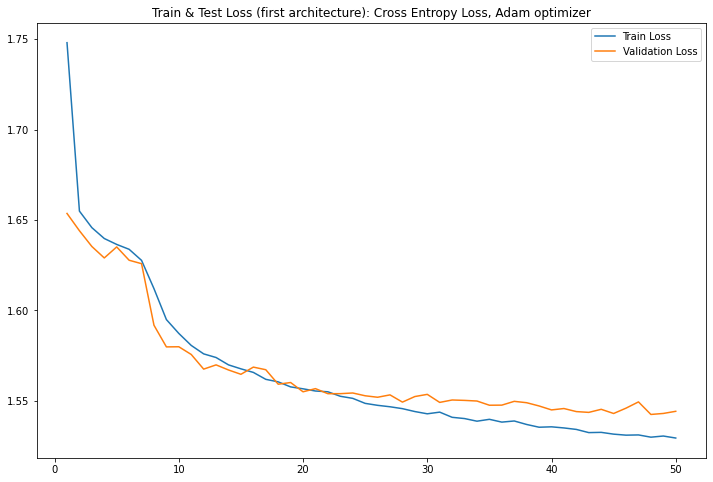

In [16]:
loss_plot(loss_train_list, loss_test_list,'first architecture', 'Adam optimizer')

In [17]:
# plot of accuracy
def accuracy_plot(train_acc,val_acc,architecture,optimizer):
    plt.figure(figsize=(12,8))
    plt.plot(list(range(1,len(train_acc)+1)), train_acc,label='Train accuracy')
    plt.plot(list(range(1,len(val_acc)+1)), val_acc,label='Validation accuracy')
    plt.title(f'Train & Test accuracy ({architecture}): Cross Entropy Loss, {optimizer}')
    plt.legend(loc=0)
    plt.show()

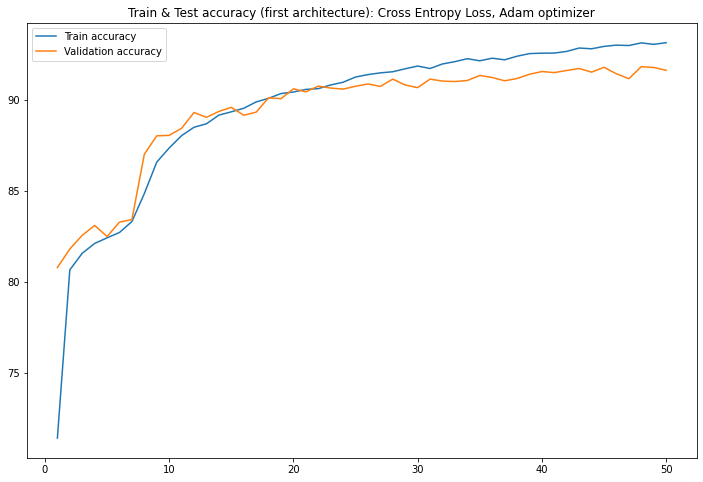

In [18]:
accuracy_plot(train_accuracy_list, test_accuracy_list,'first architecture', 'Adam optimizer')

#### Accuracy of each class:

In [19]:
# prepare to count predictions for each class
correct = {class_name: 0 for class_name in classes}
total = {class_name: 0 for class_name in classes}

# again no gradients needed
with torch.no_grad():
    for (inputs, labels) in test_loader:
        images, labels = inputs.to(device), labels.to(device)
        outputs = net_arc2(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions of each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct[classes[label]] += 1
            total[classes[label]] += 1


# print accuracy of each class
for class_name, correct_count in correct.items():
    accuracy = (float(correct_count)*100) / total[class_name]
    print(f'Accuracy of {class_name}: {accuracy:.2f} %')

Accuracy of T_shirt/Top: 85.50 %
Accuracy of Trouser: 97.60 %
Accuracy of Pullover: 85.40 %
Accuracy of Dress: 93.10 %
Accuracy of Coat: 92.20 %
Accuracy of Sandals: 97.80 %
Accuracy of Shirt: 72.10 %
Accuracy of Sneaker: 98.00 %
Accuracy of Bag: 98.00 %
Accuracy of Ankle boots: 95.80 %


#### Prediction

In [20]:
def get_predictions(net, iterator):

    net.eval()

    inputs = []
    img_classes = []
    predicts= []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)
            y_pred= net(x)
            predictions = torch.max(y_pred, 1)[1].to(device)

            inputs.append(x.cpu())
            img_classes.append(y.cpu())
            predicts.append(predictions.cpu())

    inputs = torch.cat(inputs, dim=0)
    img_classes = torch.cat(img_classes, dim=0)
    predicts = torch.cat(predicts, dim=0)

    return inputs, img_classes,predicts

In [21]:
inputs, img_classes, predicts = get_predictions(net_arc2, test_loader)

#### visualize the data:

In [22]:
#visualize the data to displays test images and their labels
def display_samples(net):
    images, labels= next(iter(test_loader))
    images, labels= images.to(device), labels.to(device)
    output= net(images)
    _, preds= torch.max(output, 1)

    images= images.cpu().numpy()

    fig= plt.figure(figsize= (15, 6))
    for index in np.arange(15):
        ax= fig.add_subplot(3, 5, index+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[index]), cmap= 'gray')
        ax.set_title(f'{classes[preds[index].item()]} / {classes[labels[index].item()]}',
                        color=('green' if preds[index]==labels[index] else 'red'))
        fig.tight_layout(pad=3)

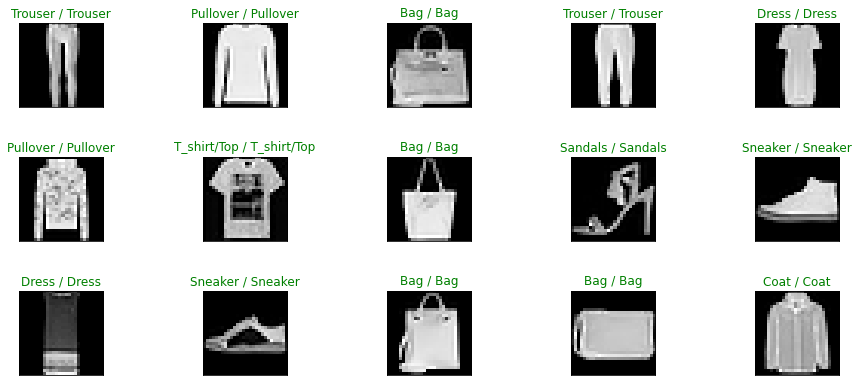

In [150]:
display_samples(net_arc2)

#### Confusion Matrix

In [24]:
lst_pred = [predictions_list[i].tolist() for i in range(len(predictions_list))]
lst_lbl = [labels_list[i].tolist() for i in range(len(labels_list))]
lst_pred = list(chain.from_iterable(lst_pred))
lst_lbl = list(chain.from_iterable(lst_lbl))

confusion_matrix(lst_lbl, lst_pred)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(lst_lbl, lst_pred)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.82      0.88      0.85     60250
           1       0.99      0.97      0.98     60250
           2       0.81      0.87      0.84     62200
           3       0.88      0.93      0.90     58900
           4       0.77      0.86      0.81     59600
           5       0.98      0.97      0.98     59250
           6       0.80      0.56      0.66     59950
           7       0.95      0.96      0.96     60000
           8       0.98      0.97      0.97     60150
           9       0.97      0.97      0.97     59450

    accuracy                           0.89    600000
   macro avg       0.89      0.89      0.89    600000
weighted avg       0.89      0.89      0.89    600000




### State 2 of first architecture: SGD Optimizer

In [33]:
net_arc2= NET_arc2().to(device)

##### Loss Function:

In [34]:
criterion = nn.CrossEntropyLoss()

##### Optimizer:

In [35]:
optimizer = optim.SGD(net_arc2.parameters(), lr=0.001, momentum=0.9)

##### Training:

In [36]:
net_arc2.to(device)
epochs = 50

loss_train_list,loss_test_list = [] , []
train_accuracy_list, test_accuracy_list = [], []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

###################################    Training     ##########################################
for epoch in range(1, epochs+1):
    total_train, total_test = 0 , 0
    correct_train, correct_test = 0 , 0


    sum_of_loss_train = 0
    net_arc2.train()
    # Loop for train batches
    loop_train = tqdm(enumerate(train_loader, 1),total=len(train_loader), desc="train")
    for i,(inputs, labels) in loop_train:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net_arc2(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #calculate loss of train data
        sum_of_loss_train += loss.item()
        loop_train.set_description(f'Train - epoch : {epoch}')
        loop_train.set_postfix(current_loss = {sum_of_loss_train/i})
        loop_train.refresh()
        #calculate accuracy of train data
        predictions_train = torch.max(outputs, 1)[1].to(device)
        correct_train += (predictions_train == labels).sum()
        total_train += len(labels)
        
    train_accuracy = correct_train * 100 / total_train   
    train_accuracy_list.append(train_accuracy.cpu()) 
                
    loss_train_list.append((sum_of_loss_train/i))

    net_arc2.to(device)
    ################################    Testing by validation data    ##############################################
    net_arc2.eval()
    with torch.no_grad():
    # Loop for test batches
        loop_test = tqdm(enumerate(validation_loader, 1),total=len(validation_loader), desc="val")
        sum_of_loss_test = 0
        for i,(inputs, labels) in loop_test:
            inputs, labels = inputs.to(device), labels.to(device)
            labels_list.append(labels)
            outputs = net_arc2(inputs)
            #calculate loss of test data
            curr_loss_test = criterion(outputs, labels)
            sum_of_loss_test += curr_loss_test.item()
            loop_test.set_description(f'Test - epoch : {epoch}')
            loop_test.set_postfix(curr_loss_test = {sum_of_loss_test/i})   
            loop_test.refresh()
            #calculate accuracy of test data
            predictions_test = torch.max(outputs, 1)[1].to(device)
            predictions_list.append(predictions_test)
            correct_test += (predictions_test == labels).sum()
            total_test += len(labels)
            
        test_accuracy = correct_test * 100 / total_test
        test_accuracy_list.append(test_accuracy.cpu())             
        
        loss_test_list.append((sum_of_loss_test/i))
            
            
            
        print(f'At Epoch {epoch}/{epochs}:  Train Loss= {loss_train_list[-1]} , Train Accuracy= {train_accuracy:.3f} %')
        print(f'At Epoch {epoch}/{epochs}: Test Loss= {loss_test_list[-1]} , Test Accuracy= {test_accuracy:.3f} %')

Test - epoch : 1: 100%|██████████| 94/94 [00:05<00:00, 17.17it/s, curr_loss_test={1.749785988888842}] 


At Epoch 1/50:  Train Loss= 1.9423867661158243 , Train Accuracy= 55.633 %
At Epoch 1/50: Test Loss= 1.749785988888842 , Test Accuracy= 72.792 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 2/50:  Train Loss= 1.7440347750981648 , Train Accuracy= 73.619 %
At Epoch 2/50: Test Loss= 1.7086359896558396 , Test Accuracy= 76.042 %


Test - epoch : 3: 100%|██████████| 94/94 [00:06<00:00, 14.36it/s, curr_loss_test={1.6957615702710254}]


At Epoch 3/50:  Train Loss= 1.7167523250579835 , Train Accuracy= 75.650 %
At Epoch 3/50: Test Loss= 1.6957615702710254 , Test Accuracy= 76.967 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 4/50:  Train Loss= 1.7023437744776408 , Train Accuracy= 76.800 %
At Epoch 4/50: Test Loss= 1.6832912412095578 , Test Accuracy= 78.500 %


Test - epoch : 5: 100%|██████████| 94/94 [00:07<00:00, 13.35it/s, curr_loss_test={1.6778413310964058}]


At Epoch 5/50:  Train Loss= 1.6945567057927449 , Train Accuracy= 77.552 %
At Epoch 5/50: Test Loss= 1.6778413310964058 , Test Accuracy= 78.817 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 6/50:  Train Loss= 1.688718095779419 , Train Accuracy= 78.000 %
At Epoch 6/50: Test Loss= 1.6711107454401382 , Test Accuracy= 79.558 %


Test - epoch : 7: 100%|██████████| 94/94 [00:05<00:00, 15.74it/s, curr_loss_test={1.6674320647057066}]


At Epoch 7/50:  Train Loss= 1.6829307339986166 , Train Accuracy= 78.429 %
At Epoch 7/50: Test Loss= 1.6674320647057066 , Test Accuracy= 79.750 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 8/50:  Train Loss= 1.6793493213653565 , Train Accuracy= 78.775 %
At Epoch 8/50: Test Loss= 1.6641077526072239 , Test Accuracy= 80.050 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 9/50:  Train Loss= 1.6761963275273641 , Train Accuracy= 79.094 %
At Epoch 9/50: Test Loss= 1.6615177710005578 , Test Accuracy= 80.242 %


Test - epoch : 10: 100%|██████████| 94/94 [00:06<00:00, 15.26it/s, curr_loss_test={1.6635238325342219}]


At Epoch 10/50:  Train Loss= 1.6733194268544516 , Train Accuracy= 79.327 %
At Epoch 10/50: Test Loss= 1.6635238325342219 , Test Accuracy= 79.958 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 11/50:  Train Loss= 1.6704410750071208 , Train Accuracy= 79.573 %
At Epoch 11/50: Test Loss= 1.6575198084750074 , Test Accuracy= 80.600 %


Test - epoch : 12: 100%|██████████| 94/94 [00:06<00:00, 15.66it/s, curr_loss_test={1.6556501718277628}]


At Epoch 12/50:  Train Loss= 1.6680711882909138 , Train Accuracy= 79.754 %
At Epoch 12/50: Test Loss= 1.6556501718277628 , Test Accuracy= 80.833 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 13/50:  Train Loss= 1.666823140780131 , Train Accuracy= 79.896 %
At Epoch 13/50: Test Loss= 1.6545316665730578 , Test Accuracy= 80.858 %


Test - epoch : 14: 100%|██████████| 94/94 [00:06<00:00, 15.07it/s, curr_loss_test={1.6529961634189525}]


At Epoch 14/50:  Train Loss= 1.664243127187093 , Train Accuracy= 80.106 %
At Epoch 14/50: Test Loss= 1.6529961634189525 , Test Accuracy= 80.942 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 15/50:  Train Loss= 1.6608634227116903 , Train Accuracy= 80.454 %
At Epoch 15/50: Test Loss= 1.652693530346485 , Test Accuracy= 80.967 %


Test - epoch : 16: 100%|██████████| 94/94 [00:05<00:00, 15.79it/s, curr_loss_test={1.6505476249025224}]


At Epoch 16/50:  Train Loss= 1.6601789401372273 , Train Accuracy= 80.552 %
At Epoch 16/50: Test Loss= 1.6505476249025224 , Test Accuracy= 81.208 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 17/50:  Train Loss= 1.657978572209676 , Train Accuracy= 80.677 %
At Epoch 17/50: Test Loss= 1.6505255889385304 , Test Accuracy= 81.075 %


Test - epoch : 18: 100%|██████████| 94/94 [00:06<00:00, 14.31it/s, curr_loss_test={1.648970680033907}] 


At Epoch 18/50:  Train Loss= 1.6575906791687012 , Train Accuracy= 80.808 %
At Epoch 18/50: Test Loss= 1.648970680033907 , Test Accuracy= 81.308 %


Test - epoch : 19: 100%|██████████| 94/94 [00:06<00:00, 15.41it/s, curr_loss_test={1.647728479923086}] 


At Epoch 19/50:  Train Loss= 1.6564305928548178 , Train Accuracy= 80.856 %
At Epoch 19/50: Test Loss= 1.647728479923086 , Test Accuracy= 81.525 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 20/50:  Train Loss= 1.6550782915751139 , Train Accuracy= 80.952 %
At Epoch 20/50: Test Loss= 1.6455234022850687 , Test Accuracy= 81.675 %


Test - epoch : 21: 100%|██████████| 94/94 [00:06<00:00, 14.92it/s, curr_loss_test={1.647613784100147}] 


At Epoch 21/50:  Train Loss= 1.65360342502594 , Train Accuracy= 81.119 %
At Epoch 21/50: Test Loss= 1.647613784100147 , Test Accuracy= 81.550 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 22/50:  Train Loss= 1.6524875005086264 , Train Accuracy= 81.240 %
At Epoch 22/50: Test Loss= 1.6446031750516688 , Test Accuracy= 81.783 %


Test - epoch : 23: 100%|██████████| 94/94 [00:05<00:00, 15.88it/s, curr_loss_test={1.6455970469941483}]


At Epoch 23/50:  Train Loss= 1.6511484018961589 , Train Accuracy= 81.387 %
At Epoch 23/50: Test Loss= 1.6455970469941483 , Test Accuracy= 81.775 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 24/50:  Train Loss= 1.651104942003886 , Train Accuracy= 81.387 %
At Epoch 24/50: Test Loss= 1.6437403673821307 , Test Accuracy= 81.850 %


Test - epoch : 25: 100%|██████████| 94/94 [00:06<00:00, 15.52it/s, curr_loss_test={1.6422280618484983}]


At Epoch 25/50:  Train Loss= 1.6497293732961018 , Train Accuracy= 81.438 %
At Epoch 25/50: Test Loss= 1.6422280618484983 , Test Accuracy= 82.050 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 26/50:  Train Loss= 1.649340288480123 , Train Accuracy= 81.531 %
At Epoch 26/50: Test Loss= 1.6415431626299595 , Test Accuracy= 82.192 %


Test - epoch : 27: 100%|██████████| 94/94 [00:05<00:00, 16.20it/s, curr_loss_test={1.6417879145196144}]


At Epoch 27/50:  Train Loss= 1.6472276366551717 , Train Accuracy= 81.758 %
At Epoch 27/50: Test Loss= 1.6417879145196144 , Test Accuracy= 82.008 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 28/50:  Train Loss= 1.6478625745773317 , Train Accuracy= 81.615 %
At Epoch 28/50: Test Loss= 1.6414366148887796 , Test Accuracy= 82.142 %


Test - epoch : 29: 100%|██████████| 94/94 [00:07<00:00, 13.14it/s, curr_loss_test={1.6393689589297518}]


At Epoch 29/50:  Train Loss= 1.646750867207845 , Train Accuracy= 81.708 %
At Epoch 29/50: Test Loss= 1.6393689589297518 , Test Accuracy= 82.292 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 30/50:  Train Loss= 1.6458077217737834 , Train Accuracy= 81.808 %
At Epoch 30/50: Test Loss= 1.6392010894227536 , Test Accuracy= 82.267 %


Test - epoch : 31: 100%|██████████| 94/94 [00:06<00:00, 15.18it/s, curr_loss_test={1.6381109255425474}]


At Epoch 31/50:  Train Loss= 1.6443981523513793 , Train Accuracy= 81.965 %
At Epoch 31/50: Test Loss= 1.6381109255425474 , Test Accuracy= 82.475 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 32/50:  Train Loss= 1.643705005645752 , Train Accuracy= 82.031 %
At Epoch 32/50: Test Loss= 1.638159916756001 , Test Accuracy= 82.483 %


Test - epoch : 33: 100%|██████████| 94/94 [00:06<00:00, 13.97it/s, curr_loss_test={1.6380192231624684}]


At Epoch 33/50:  Train Loss= 1.6442168931961059 , Train Accuracy= 81.977 %
At Epoch 33/50: Test Loss= 1.6380192231624684 , Test Accuracy= 82.475 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 34/50:  Train Loss= 1.6425017239252726 , Train Accuracy= 82.146 %
At Epoch 34/50: Test Loss= 1.6370833541484588 , Test Accuracy= 82.533 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 35/50:  Train Loss= 1.6426230770746866 , Train Accuracy= 82.079 %
At Epoch 35/50: Test Loss= 1.6360440900985231 , Test Accuracy= 82.675 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 36/50:  Train Loss= 1.6417325372695923 , Train Accuracy= 82.229 %
At Epoch 36/50: Test Loss= 1.6360299041930666 , Test Accuracy= 82.650 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 37/50:  Train Loss= 1.6420735842386882 , Train Accuracy= 82.204 %
At Epoch 37/50: Test Loss= 1.635440910116155 , Test Accuracy= 82.750 %


Test - epoch : 38: 100%|██████████| 94/94 [00:05<00:00, 15.91it/s, curr_loss_test={1.6370149888890855}]


At Epoch 38/50:  Train Loss= 1.6408376143773398 , Train Accuracy= 82.254 %
At Epoch 38/50: Test Loss= 1.6370149888890855 , Test Accuracy= 82.608 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 39/50:  Train Loss= 1.6393022464116414 , Train Accuracy= 82.442 %
At Epoch 39/50: Test Loss= 1.6346882277346673 , Test Accuracy= 82.817 %


Test - epoch : 40: 100%|██████████| 94/94 [00:05<00:00, 16.12it/s, curr_loss_test={1.6352130440955466}]


At Epoch 40/50:  Train Loss= 1.6398524672190349 , Train Accuracy= 82.375 %
At Epoch 40/50: Test Loss= 1.6352130440955466 , Test Accuracy= 82.725 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 41/50:  Train Loss= 1.6391601921717325 , Train Accuracy= 82.506 %
At Epoch 41/50: Test Loss= 1.635148252578492 , Test Accuracy= 82.825 %


Test - epoch : 42: 100%|██████████| 94/94 [00:06<00:00, 14.09it/s, curr_loss_test={1.6337933426207685}]


At Epoch 42/50:  Train Loss= 1.637758527437846 , Train Accuracy= 82.575 %
At Epoch 42/50: Test Loss= 1.6337933426207685 , Test Accuracy= 82.875 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 43/50:  Train Loss= 1.6381418886184693 , Train Accuracy= 82.529 %
At Epoch 43/50: Test Loss= 1.6339714970994503 , Test Accuracy= 82.808 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 44/50:  Train Loss= 1.6375935538609823 , Train Accuracy= 82.615 %
At Epoch 44/50: Test Loss= 1.6333192016216034 , Test Accuracy= 83.008 %


Test - epoch : 45: 100%|██████████| 94/94 [00:08<00:00, 11.34it/s, curr_loss_test={1.6341239556353142}]


At Epoch 45/50:  Train Loss= 1.636004667599996 , Train Accuracy= 82.852 %
At Epoch 45/50: Test Loss= 1.6341239556353142 , Test Accuracy= 82.983 %


Test - epoch : 46: 100%|██████████| 94/94 [00:08<00:00, 11.38it/s, curr_loss_test={1.6343989359571578}]


At Epoch 46/50:  Train Loss= 1.6360632088979086 , Train Accuracy= 82.756 %
At Epoch 46/50: Test Loss= 1.6343989359571578 , Test Accuracy= 82.742 %


Test - epoch : 47: 100%|██████████| 94/94 [00:08<00:00, 10.55it/s, curr_loss_test={1.633567103680144}] 


At Epoch 47/50:  Train Loss= 1.6370428342819214 , Train Accuracy= 82.588 %
At Epoch 47/50: Test Loss= 1.633567103680144 , Test Accuracy= 82.925 %


Test - epoch : 48: 100%|██████████| 94/94 [00:19<00:00,  4.70it/s, curr_loss_test={1.6315452849611323}]


At Epoch 48/50:  Train Loss= 1.6363239768346152 , Train Accuracy= 82.737 %
At Epoch 48/50: Test Loss= 1.6315452849611323 , Test Accuracy= 83.075 %


Test - epoch : 49: 100%|██████████| 94/94 [00:12<00:00,  7.27it/s, curr_loss_test={1.6308215450733266}]


At Epoch 49/50:  Train Loss= 1.635011614481608 , Train Accuracy= 82.854 %
At Epoch 49/50: Test Loss= 1.6308215450733266 , Test Accuracy= 83.133 %


Test - epoch : 50: 100%|██████████| 94/94 [00:10<00:00,  8.75it/s, curr_loss_test={1.6318111800132913}]

At Epoch 50/50:  Train Loss= 1.6350815957387288 , Train Accuracy= 82.838 %
At Epoch 50/50: Test Loss= 1.6318111800132913 , Test Accuracy= 83.042 %


##### Plotting Loss and Accuracy:

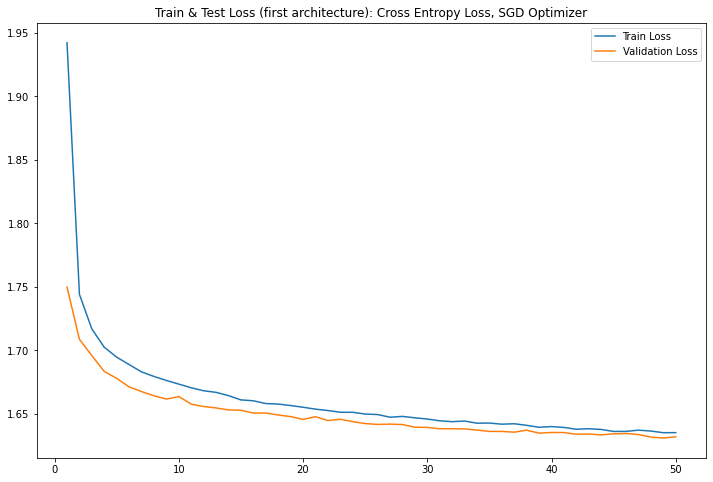

In [37]:
loss_plot(loss_train_list, loss_test_list,'first architecture','SGD Optimizer')

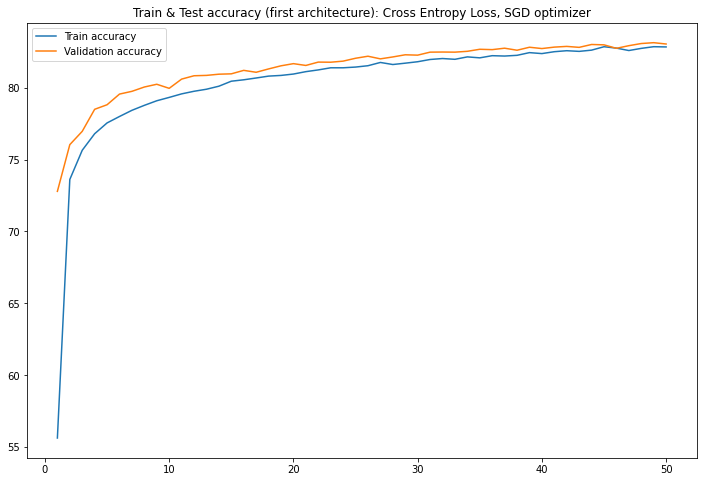

In [38]:
accuracy_plot(train_accuracy_list, test_accuracy_list,'first architecture', 'SGD optimizer')

##### Plotting Loss and Accuracy:

#### Accuracy of each class:

In [39]:
# prepare to count predictions for each class
correct = {class_name: 0 for class_name in classes}
total = {class_name: 0 for class_name in classes}

# again no gradients needed
with torch.no_grad():
    for (inputs, labels) in test_loader:
        images, labels = inputs.to(device), labels.to(device)
        outputs = net_arc2(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions of each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct[classes[label]] += 1
            total[classes[label]] += 1


# print accuracy of each class
for class_name, correct_count in correct.items():
    accuracy = (float(correct_count)*100) / total[class_name]
    print(f'Accuracy of {class_name}: {accuracy:.2f} %')

Accuracy of T_shirt/Top: 88.70 %
Accuracy of Trouser: 95.90 %
Accuracy of Pullover: 85.80 %
Accuracy of Dress: 91.60 %
Accuracy of Coat: 86.70 %
Accuracy of Sandals: 93.80 %
Accuracy of Shirt: 0.00 %
Accuracy of Sneaker: 95.90 %
Accuracy of Bag: 97.10 %
Accuracy of Ankle boots: 94.50 %


#### Confusion Matrix

In [40]:
lst_pred = [predictions_list[i].tolist() for i in range(len(predictions_list))]
lst_lbl = [labels_list[i].tolist() for i in range(len(labels_list))]
lst_pred = list(chain.from_iterable(lst_pred))
lst_lbl = list(chain.from_iterable(lst_lbl))

confusion_matrix(lst_lbl, lst_pred)
print("Classification report :\n%s\n"
      % (metrics.classification_report(lst_lbl, lst_pred)))

c:\Users\Anni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Anni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for CNN :
              precision    recall  f1-score   support

           0       0.71      0.89      0.79     60250
           1       0.98      0.96      0.97     60250
           2       0.66      0.79      0.72     62200
           3       0.83      0.91      0.87     58900
           4       0.60      0.86      0.70     59600
           5       0.93      0.92      0.93     59250
           6       0.00      0.00      0.00     59950
           7       0.90      0.92      0.91     60000
           8       0.93      0.95      0.94     60150
           9       0.94      0.95      0.94     59450

    accuracy                           0.81    600000
   macro avg       0.75      0.81      0.78    600000
weighted avg       0.75      0.81      0.78    600000




c:\Users\Anni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<hr/>
<hr/>

## Second Architecture: architecture3

In [41]:
#architecture3
class NET_arc3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1= nn.Conv2d(1,64,2)
        self.pool = nn.MaxPool2d((2, 2))
        self.drop = nn.Dropout(0.25)
        self.conv2= nn.Conv2d(64,64,2)
        self.conv3= nn.Conv2d(64,64,2)
        self.fc1= nn.Linear(1600,64)
        self.fc2= nn.Linear(64,10)
        
    def forward(self, x):
        x= self.pool(F.relu(self.conv1(x)))
        x= self.drop(x)
        
        x= self.pool(F.relu(self.conv2(x)))
        x = self.drop(x)
        
        x= F.relu(self.conv3(x))
        x = self.drop(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x= self.drop(x)
        
        x = F.softmax(self.fc2(x), dim=1)
        
        return x
        

In [42]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### State 1 of second architecture: Adam Optimizer

In [43]:
net_arc3= NET_arc3().to(device)

##### Loss Function:

In [44]:
criterion = nn.CrossEntropyLoss()

##### Optimizer:

In [45]:
learning_rate = 0.001
optimizer = torch.optim.Adam(net_arc3.parameters(), lr=learning_rate)

##### Training:

In [46]:
net_arc3.to(device)
epochs = 50

loss_train_list,loss_test_list = [] , []
train_accuracy_list, test_accuracy_list = [], []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

###################################    Training     ##########################################
for epoch in range(1, epochs+1):
    total_train, total_test = 0 , 0
    correct_train, correct_test = 0 , 0


    sum_of_loss_train = 0
    net_arc3.train()
    # Loop for train batches
    loop_train = tqdm(enumerate(train_loader, 1),total=len(train_loader), desc="train")
    for i,(inputs, labels) in loop_train:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net_arc3(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #calculate loss of train data
        sum_of_loss_train += loss.item()
        loop_train.set_description(f'Train - epoch : {epoch}')
        loop_train.set_postfix(current_loss = {sum_of_loss_train/i})
        loop_train.refresh()
        #calculate accuracy of train data
        predictions_train = torch.max(outputs, 1)[1].to(device)
        correct_train += (predictions_train == labels).sum()
        total_train += len(labels)
        
    train_accuracy = correct_train * 100 / total_train   
    train_accuracy_list.append(train_accuracy.cpu()) 
                
    loss_train_list.append((sum_of_loss_train/i))

    net_arc3.to(device)
    ################################    Testing by validation data    ##############################################
    net_arc3.eval()
    with torch.no_grad():
    # Loop for test batches
        loop_test = tqdm(enumerate(validation_loader, 1),total=len(validation_loader), desc="val")
        sum_of_loss_test = 0
        for i,(inputs, labels) in loop_test:
            inputs, labels = inputs.to(device), labels.to(device)
            labels_list.append(labels)
            outputs = net_arc3(inputs)
            #calculate loss of test data
            curr_loss_test = criterion(outputs, labels)
            sum_of_loss_test += curr_loss_test.item()
            loop_test.set_description(f'Test - epoch : {epoch}')
            loop_test.set_postfix(curr_loss_test = {sum_of_loss_test/i})   
            loop_test.refresh()
            #calculate accuracy of test data
            predictions_test = torch.max(outputs, 1)[1].to(device)
            predictions_list.append(predictions_test)
            correct_test += (predictions_test == labels).sum()
            total_test += len(labels)
            
        test_accuracy = correct_test * 100 / total_test
        test_accuracy_list.append(test_accuracy.cpu())             
        
        loss_test_list.append((sum_of_loss_test/i))
            
            
            
        print(f'At Epoch {epoch}/{epochs}:  Train Loss= {loss_train_list[-1]} , Train Accuracy= {train_accuracy:.3f} %')
        print(f'At Epoch {epoch}/{epochs}: Test Loss= {loss_test_list[-1]} , Test Accuracy= {test_accuracy:.3f} %')

Test - epoch : 1: 100%|██████████| 94/94 [00:09<00:00,  9.48it/s, curr_loss_test={1.6689445972442627}]


At Epoch 1/50:  Train Loss= 1.7677597783406576 , Train Accuracy= 69.506 %
At Epoch 1/50: Test Loss= 1.6689445972442627 , Test Accuracy= 79.325 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 2/50:  Train Loss= 1.6668781496683756 , Train Accuracy= 79.552 %
At Epoch 2/50: Test Loss= 1.6394306154961282 , Test Accuracy= 82.200 %


Test - epoch : 3: 100%|██████████| 94/94 [00:05<00:00, 16.14it/s, curr_loss_test={1.6208812442231686}]


At Epoch 3/50:  Train Loss= 1.6458618672688803 , Train Accuracy= 81.567 %
At Epoch 3/50: Test Loss= 1.6208812442231686 , Test Accuracy= 83.858 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 4/50:  Train Loss= 1.6334998737970987 , Train Accuracy= 82.810 %
At Epoch 4/50: Test Loss= 1.6107578074678461 , Test Accuracy= 85.083 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 5/50:  Train Loss= 1.6205743529001873 , Train Accuracy= 84.052 %
At Epoch 5/50: Test Loss= 1.6069873761623463 , Test Accuracy= 85.325 %


Test - epoch : 6: 100%|██████████| 94/94 [00:05<00:00, 18.55it/s, curr_loss_test={1.6025777662054022}]


At Epoch 6/50:  Train Loss= 1.6165072743097941 , Train Accuracy= 84.385 %
At Epoch 6/50: Test Loss= 1.6025777662054022 , Test Accuracy= 85.867 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 7/50:  Train Loss= 1.6098154287338258 , Train Accuracy= 85.092 %
At Epoch 7/50: Test Loss= 1.5936970393708412 , Test Accuracy= 86.667 %


Test - epoch : 8: 100%|██████████| 94/94 [00:06<00:00, 15.16it/s, curr_loss_test={1.5945657364865566}]


At Epoch 8/50:  Train Loss= 1.6055595045089721 , Train Accuracy= 85.604 %
At Epoch 8/50: Test Loss= 1.5945657364865566 , Test Accuracy= 86.575 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 9/50:  Train Loss= 1.601362496058146 , Train Accuracy= 85.950 %
At Epoch 9/50: Test Loss= 1.5848562679392226 , Test Accuracy= 87.592 %


Test - epoch : 10: 100%|██████████| 94/94 [00:07<00:00, 12.15it/s, curr_loss_test={1.5838378541013027}]


At Epoch 10/50:  Train Loss= 1.5976266740163168 , Train Accuracy= 86.360 %
At Epoch 10/50: Test Loss= 1.5838378541013027 , Test Accuracy= 87.750 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 11/50:  Train Loss= 1.5935793116887411 , Train Accuracy= 86.685 %
At Epoch 11/50: Test Loss= 1.5801785626309983 , Test Accuracy= 88.008 %


Test - epoch : 12: 100%|██████████| 94/94 [00:11<00:00,  8.13it/s, curr_loss_test={1.5767877672580963}]


At Epoch 12/50:  Train Loss= 1.5918191951115925 , Train Accuracy= 86.917 %
At Epoch 12/50: Test Loss= 1.5767877672580963 , Test Accuracy= 88.458 %


Test - epoch : 13: 100%|██████████| 94/94 [00:08<00:00, 11.64it/s, curr_loss_test={1.572632650111584}] 


At Epoch 13/50:  Train Loss= 1.5909167194366456 , Train Accuracy= 86.981 %
At Epoch 13/50: Test Loss= 1.572632650111584 , Test Accuracy= 88.792 %


Test - epoch : 14: 100%|██████████| 94/94 [00:09<00:00, 10.41it/s, curr_loss_test={1.5764861385873024}]


At Epoch 14/50:  Train Loss= 1.5896349700291952 , Train Accuracy= 87.052 %
At Epoch 14/50: Test Loss= 1.5764861385873024 , Test Accuracy= 88.450 %


Test - epoch : 15: 100%|██████████| 94/94 [00:08<00:00, 10.91it/s, curr_loss_test={1.572503462750861}] 


At Epoch 15/50:  Train Loss= 1.5844886910120646 , Train Accuracy= 87.627 %
At Epoch 15/50: Test Loss= 1.572503462750861 , Test Accuracy= 88.817 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 16/50:  Train Loss= 1.5821862490971883 , Train Accuracy= 87.892 %
At Epoch 16/50: Test Loss= 1.5704239162992923 , Test Accuracy= 88.958 %


Test - epoch : 17: 100%|██████████| 94/94 [00:06<00:00, 15.32it/s, curr_loss_test={1.5695912723845624}]


At Epoch 17/50:  Train Loss= 1.5801452112197876 , Train Accuracy= 88.060 %
At Epoch 17/50: Test Loss= 1.5695912723845624 , Test Accuracy= 89.142 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 18/50:  Train Loss= 1.5802610410054525 , Train Accuracy= 88.035 %
At Epoch 18/50: Test Loss= 1.5683918684086902 , Test Accuracy= 89.233 %


Test - epoch : 19: 100%|██████████| 94/94 [00:07<00:00, 11.93it/s, curr_loss_test={1.5677219401014613}]


At Epoch 19/50:  Train Loss= 1.580258144378662 , Train Accuracy= 88.037 %
At Epoch 19/50: Test Loss= 1.5677219401014613 , Test Accuracy= 89.317 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 20/50:  Train Loss= 1.5784028323491415 , Train Accuracy= 88.215 %
At Epoch 20/50: Test Loss= 1.5692930969786136 , Test Accuracy= 89.150 %


Test - epoch : 21: 100%|██████████| 94/94 [00:06<00:00, 15.30it/s, curr_loss_test={1.5654903701011171}]


At Epoch 21/50:  Train Loss= 1.5779762468338012 , Train Accuracy= 88.310 %
At Epoch 21/50: Test Loss= 1.5654903701011171 , Test Accuracy= 89.517 %


Test - epoch : 22: 100%|██████████| 94/94 [00:06<00:00, 14.94it/s, curr_loss_test={1.5643488815490236}]


At Epoch 22/50:  Train Loss= 1.5762101351420084 , Train Accuracy= 88.469 %
At Epoch 22/50: Test Loss= 1.5643488815490236 , Test Accuracy= 89.600 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 23/50:  Train Loss= 1.57609818871816 , Train Accuracy= 88.498 %
At Epoch 23/50: Test Loss= 1.566746692708198 , Test Accuracy= 89.358 %


Test - epoch : 24: 100%|██████████| 94/94 [00:05<00:00, 15.92it/s, curr_loss_test={1.5663652191770838}]


At Epoch 24/50:  Train Loss= 1.576843253135681 , Train Accuracy= 88.421 %
At Epoch 24/50: Test Loss= 1.5663652191770838 , Test Accuracy= 89.400 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 25/50:  Train Loss= 1.5739453757603963 , Train Accuracy= 88.662 %
At Epoch 25/50: Test Loss= 1.5611303664268332 , Test Accuracy= 90.025 %


Test - epoch : 26: 100%|██████████| 94/94 [00:06<00:00, 14.90it/s, curr_loss_test={1.5587351689947413}]


At Epoch 26/50:  Train Loss= 1.5730550190607706 , Train Accuracy= 88.798 %
At Epoch 26/50: Test Loss= 1.5587351689947413 , Test Accuracy= 90.200 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 27/50:  Train Loss= 1.5701251366933187 , Train Accuracy= 89.088 %
At Epoch 27/50: Test Loss= 1.5597516945067873 , Test Accuracy= 90.058 %


Test - epoch : 28: 100%|██████████| 94/94 [00:06<00:00, 13.75it/s, curr_loss_test={1.5612170873804296}]


At Epoch 28/50:  Train Loss= 1.5719149576822917 , Train Accuracy= 88.877 %
At Epoch 28/50: Test Loss= 1.5612170873804296 , Test Accuracy= 89.908 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 29/50:  Train Loss= 1.5729615252812703 , Train Accuracy= 88.794 %
At Epoch 29/50: Test Loss= 1.567390813472423 , Test Accuracy= 89.333 %


Test - epoch : 30: 100%|██████████| 94/94 [00:05<00:00, 15.90it/s, curr_loss_test={1.5772384620727378}]


At Epoch 30/50:  Train Loss= 1.5726246608098349 , Train Accuracy= 88.800 %
At Epoch 30/50: Test Loss= 1.5772384620727378 , Test Accuracy= 88.300 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 31/50:  Train Loss= 1.5702299795150756 , Train Accuracy= 89.069 %
At Epoch 31/50: Test Loss= 1.5594490956752858 , Test Accuracy= 90.233 %


Test - epoch : 32: 100%|██████████| 94/94 [00:05<00:00, 15.82it/s, curr_loss_test={1.5616846287504156}]


At Epoch 32/50:  Train Loss= 1.5711131992340088 , Train Accuracy= 88.979 %
At Epoch 32/50: Test Loss= 1.5616846287504156 , Test Accuracy= 89.917 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 33/50:  Train Loss= 1.5689008636474608 , Train Accuracy= 89.223 %
At Epoch 33/50: Test Loss= 1.5616124614756157 , Test Accuracy= 89.900 %


Test - epoch : 34: 100%|██████████| 94/94 [00:06<00:00, 15.66it/s, curr_loss_test={1.5620649101886344}]


At Epoch 34/50:  Train Loss= 1.5713937362035115 , Train Accuracy= 88.983 %
At Epoch 34/50: Test Loss= 1.5620649101886344 , Test Accuracy= 89.833 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 35/50:  Train Loss= 1.570578841527303 , Train Accuracy= 88.992 %
At Epoch 35/50: Test Loss= 1.5597079954248794 , Test Accuracy= 90.100 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 36/50:  Train Loss= 1.5664370409647623 , Train Accuracy= 89.450 %
At Epoch 36/50: Test Loss= 1.5561326323671545 , Test Accuracy= 90.425 %


Test - epoch : 37: 100%|██████████| 94/94 [00:07<00:00, 11.76it/s, curr_loss_test={1.5570842966120293}]


At Epoch 37/50:  Train Loss= 1.5690135946273804 , Train Accuracy= 89.173 %
At Epoch 37/50: Test Loss= 1.5570842966120293 , Test Accuracy= 90.350 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 38/50:  Train Loss= 1.5713564132054647 , Train Accuracy= 88.967 %
At Epoch 38/50: Test Loss= 1.5593194644501869 , Test Accuracy= 90.150 %


Test - epoch : 39: 100%|██████████| 94/94 [00:07<00:00, 13.28it/s, curr_loss_test={1.5572136881503653}]


At Epoch 39/50:  Train Loss= 1.5695997937520345 , Train Accuracy= 89.102 %
At Epoch 39/50: Test Loss= 1.5572136881503653 , Test Accuracy= 90.333 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 40/50:  Train Loss= 1.5685105460484823 , Train Accuracy= 89.246 %
At Epoch 40/50: Test Loss= 1.5563202145251822 , Test Accuracy= 90.475 %


Test - epoch : 41: 100%|██████████| 94/94 [00:06<00:00, 15.23it/s, curr_loss_test={1.5581561644026574}]


At Epoch 41/50:  Train Loss= 1.567275298754374 , Train Accuracy= 89.344 %
At Epoch 41/50: Test Loss= 1.5581561644026574 , Test Accuracy= 90.233 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 42/50:  Train Loss= 1.5669361038208007 , Train Accuracy= 89.406 %
At Epoch 42/50: Test Loss= 1.558391810731685 , Test Accuracy= 90.217 %


Test - epoch : 43: 100%|██████████| 94/94 [00:05<00:00, 16.11it/s, curr_loss_test={1.5623005121312243}]


At Epoch 43/50:  Train Loss= 1.5662397022247314 , Train Accuracy= 89.463 %
At Epoch 43/50: Test Loss= 1.5623005121312243 , Test Accuracy= 89.892 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 44/50:  Train Loss= 1.5676112804412843 , Train Accuracy= 89.321 %
At Epoch 44/50: Test Loss= 1.5579372669788116 , Test Accuracy= 90.283 %


Test - epoch : 45: 100%|██████████| 94/94 [00:05<00:00, 15.71it/s, curr_loss_test={1.5559964433629463}]


At Epoch 45/50:  Train Loss= 1.5669827578862507 , Train Accuracy= 89.371 %
At Epoch 45/50: Test Loss= 1.5559964433629463 , Test Accuracy= 90.475 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 46/50:  Train Loss= 1.5669368543624878 , Train Accuracy= 89.383 %
At Epoch 46/50: Test Loss= 1.557715355081761 , Test Accuracy= 90.308 %


Test - epoch : 47: 100%|██████████| 94/94 [00:05<00:00, 15.99it/s, curr_loss_test={1.558014102438663}] 


At Epoch 47/50:  Train Loss= 1.5680411904652913 , Train Accuracy= 89.283 %
At Epoch 47/50: Test Loss= 1.558014102438663 , Test Accuracy= 90.300 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 48/50:  Train Loss= 1.568681367556254 , Train Accuracy= 89.208 %
At Epoch 48/50: Test Loss= 1.5589444256843406 , Test Accuracy= 90.258 %


Test - epoch : 49: 100%|██████████| 94/94 [00:06<00:00, 13.72it/s, curr_loss_test={1.556870809260835}] 


At Epoch 49/50:  Train Loss= 1.5658292690912883 , Train Accuracy= 89.469 %
At Epoch 49/50: Test Loss= 1.556870809260835 , Test Accuracy= 90.392 %


Test - epoch : 50: 100%|██████████| 94/94 [00:06<00:00, 14.46it/s, curr_loss_test={1.5588377866339176}]

At Epoch 50/50:  Train Loss= 1.5667270453770956 , Train Accuracy= 89.410 %
At Epoch 50/50: Test Loss= 1.5588377866339176 , Test Accuracy= 90.183 %


##### Plotting Loss and Accuracy:

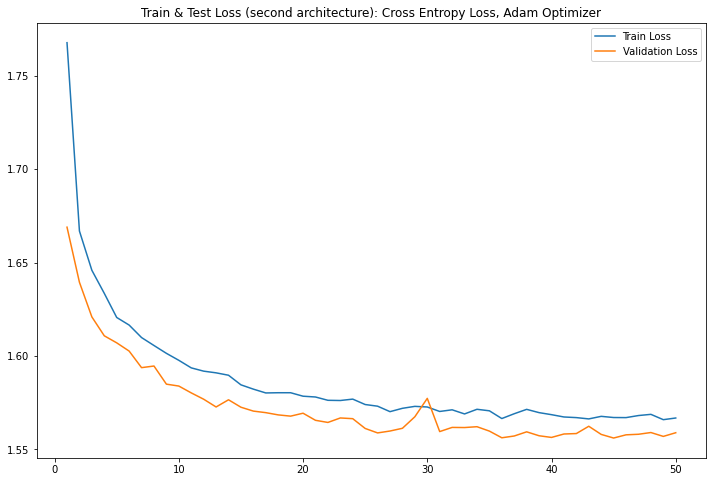

In [47]:
loss_plot(loss_train_list, loss_test_list,'second architecture','Adam Optimizer')

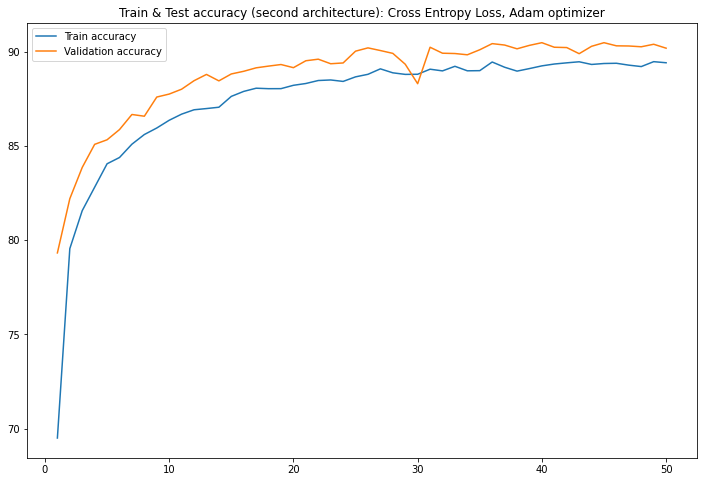

In [48]:
accuracy_plot(train_accuracy_list, test_accuracy_list,'second architecture', 'Adam optimizer')


#### Accuracy of each class:

In [49]:
# prepare to count predictions for each class
correct = {class_name: 0 for class_name in classes}
total = {class_name: 0 for class_name in classes}

# again no gradients needed
with torch.no_grad():
    for (inputs, labels) in test_loader:
        images, labels = inputs.to(device), labels.to(device)
        outputs = net_arc2(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions of each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct[classes[label]] += 1
            total[classes[label]] += 1


# print accuracy of each class
for class_name, correct_count in correct.items():
    accuracy = (float(correct_count)*100) / total[class_name]
    print(f'Accuracy of {class_name}: {accuracy:.2f} %')

Accuracy of T_shirt/Top: 88.70 %
Accuracy of Trouser: 95.90 %
Accuracy of Pullover: 85.80 %
Accuracy of Dress: 91.60 %
Accuracy of Coat: 86.70 %
Accuracy of Sandals: 93.80 %
Accuracy of Shirt: 0.00 %
Accuracy of Sneaker: 95.90 %
Accuracy of Bag: 97.10 %
Accuracy of Ankle boots: 94.50 %


#### Confusion Matrix

In [50]:
lst_pred = [predictions_list[i].tolist() for i in range(len(predictions_list))]
lst_lbl = [labels_list[i].tolist() for i in range(len(labels_list))]
lst_pred = list(chain.from_iterable(lst_pred))
lst_lbl = list(chain.from_iterable(lst_lbl))

confusion_matrix(lst_lbl, lst_pred)
print("Classification report:\n%s\n"
      % (metrics.classification_report(lst_lbl, lst_pred)))

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     60250
           1       0.98      0.97      0.98     60250
           2       0.81      0.85      0.83     62200
           3       0.87      0.91      0.89     58900
           4       0.79      0.83      0.81     59600
           5       0.97      0.96      0.97     59250
           6       0.76      0.61      0.68     59950
           7       0.94      0.95      0.95     60000
           8       0.97      0.97      0.97     60150
           9       0.96      0.96      0.96     59450

    accuracy                           0.89    600000
   macro avg       0.89      0.89      0.89    600000
weighted avg       0.89      0.89      0.89    600000




### State 2 of second architecture: SGD Optimizer

In [51]:
net_arc3= NET_arc3().to(device)

##### Loss Function:

In [52]:
criterion = nn.CrossEntropyLoss()

##### Optimizer:

In [53]:
optimizer = optim.SGD(net_arc3.parameters(), lr=0.001, momentum=0.9)

##### Training:

In [54]:
net_arc3.to(device)
epochs = 50

loss_train_list,loss_test_list = [] , []
train_accuracy_list, test_accuracy_list = [], []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

###################################    Training     ##########################################
for epoch in range(1, epochs+1):
    total_train, total_test = 0 , 0
    correct_train, correct_test = 0 , 0


    sum_of_loss_train = 0
    net_arc3.train()
    # Loop for train batches
    loop_train = tqdm(enumerate(train_loader, 1),total=len(train_loader), desc="train")
    for i,(inputs, labels) in loop_train:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net_arc3(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #calculate loss of train data
        sum_of_loss_train += loss.item()
        loop_train.set_description(f'Train - epoch : {epoch}')
        loop_train.set_postfix(current_loss = {sum_of_loss_train/i})
        loop_train.refresh()
        #calculate accuracy of train data
        predictions_train = torch.max(outputs, 1)[1].to(device)
        correct_train += (predictions_train == labels).sum()
        total_train += len(labels)
        
    train_accuracy = correct_train * 100 / total_train   
    train_accuracy_list.append(train_accuracy.cpu()) 
                
    loss_train_list.append((sum_of_loss_train/i))

    net_arc3.to(device)
    ################################    Testing by validation data    ##############################################
    net_arc3.eval()
    with torch.no_grad():
    # Loop for test batches
        loop_test = tqdm(enumerate(validation_loader, 1),total=len(validation_loader), desc="val")
        sum_of_loss_test = 0
        for i,(inputs, labels) in loop_test:
            inputs, labels = inputs.to(device), labels.to(device)
            labels_list.append(labels)
            outputs = net_arc3(inputs)
            #calculate loss of test data
            curr_loss_test = criterion(outputs, labels)
            sum_of_loss_test += curr_loss_test.item()
            loop_test.set_description(f'Test - epoch : {epoch}')
            loop_test.set_postfix(curr_loss_test = {sum_of_loss_test/i})   
            loop_test.refresh()
            #calculate accuracy of test data
            predictions_test = torch.max(outputs, 1)[1].to(device)
            predictions_list.append(predictions_test)
            correct_test += (predictions_test == labels).sum()
            total_test += len(labels)
            
        test_accuracy = correct_test * 100 / total_test
        test_accuracy_list.append(test_accuracy.cpu())             
        
        loss_test_list.append((sum_of_loss_test/i))
            
            
            
        print(f'At Epoch {epoch}/{epochs}:  Train Loss= {loss_train_list[-1]} , Train Accuracy= {train_accuracy:.3f} %')
        print(f'At Epoch {epoch}/{epochs}: Test Loss= {loss_test_list[-1]} , Test Accuracy= {test_accuracy:.3f} %')

train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 1/50:  Train Loss= 2.302266716003418 , Train Accuracy= 11.062 %
At Epoch 1/50: Test Loss= 2.3020568730983326 , Test Accuracy= 11.858 %


Test - epoch : 2: 100%|██████████| 94/94 [00:05<00:00, 16.32it/s, curr_loss_test={2.30118528325507}]  


At Epoch 2/50:  Train Loss= 2.301534823735555 , Train Accuracy= 13.910 %
At Epoch 2/50: Test Loss= 2.30118528325507 , Test Accuracy= 17.158 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 3/50:  Train Loss= 2.3003350671132408 , Train Accuracy= 16.881 %
At Epoch 3/50: Test Loss= 2.2997004985809326 , Test Accuracy= 21.600 %


Test - epoch : 4: 100%|██████████| 94/94 [00:05<00:00, 16.25it/s, curr_loss_test={2.2963142192110104}]


At Epoch 4/50:  Train Loss= 2.297814690907796 , Train Accuracy= 20.927 %
At Epoch 4/50: Test Loss= 2.2963142192110104 , Test Accuracy= 22.908 %


Test - epoch : 5: 100%|██████████| 94/94 [00:06<00:00, 15.62it/s, curr_loss_test={2.2828900661874325}]


At Epoch 5/50:  Train Loss= 2.2900181191762288 , Train Accuracy= 24.767 %
At Epoch 5/50: Test Loss= 2.2828900661874325 , Test Accuracy= 27.608 %


Test - epoch : 6: 100%|██████████| 94/94 [00:06<00:00, 14.49it/s, curr_loss_test={2.169741100453316}] 


At Epoch 6/50:  Train Loss= 2.242934777577718 , Train Accuracy= 26.894 %
At Epoch 6/50: Test Loss= 2.169741100453316 , Test Accuracy= 37.133 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 7/50:  Train Loss= 2.042533513387044 , Train Accuracy= 46.638 %
At Epoch 7/50: Test Loss= 1.9197059083492198 , Test Accuracy= 59.842 %


Test - epoch : 8: 100%|██████████| 94/94 [00:05<00:00, 16.44it/s, curr_loss_test={1.8510755642931511}]


At Epoch 8/50:  Train Loss= 1.9050085423787435 , Train Accuracy= 58.121 %
At Epoch 8/50: Test Loss= 1.8510755642931511 , Test Accuracy= 62.508 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 9/50:  Train Loss= 1.8598978522618612 , Train Accuracy= 61.442 %
At Epoch 9/50: Test Loss= 1.8217537529925083 , Test Accuracy= 64.608 %


Test - epoch : 10: 100%|██████████| 94/94 [00:05<00:00, 17.75it/s, curr_loss_test={1.7871981592888528}]


At Epoch 10/50:  Train Loss= 1.8317508163452147 , Train Accuracy= 64.010 %
At Epoch 10/50: Test Loss= 1.7871981592888528 , Test Accuracy= 68.358 %


Test - epoch : 11: 100%|██████████| 94/94 [00:05<00:00, 17.54it/s, curr_loss_test={1.7657656999344522}]


At Epoch 11/50:  Train Loss= 1.8007028566996257 , Train Accuracy= 67.402 %
At Epoch 11/50: Test Loss= 1.7657656999344522 , Test Accuracy= 70.783 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 12/50:  Train Loss= 1.7833737726211547 , Train Accuracy= 68.892 %
At Epoch 12/50: Test Loss= 1.749790554350995 , Test Accuracy= 72.133 %


Test - epoch : 13: 100%|██████████| 94/94 [00:05<00:00, 17.78it/s, curr_loss_test={1.748843843632556}] 


At Epoch 13/50:  Train Loss= 1.774654904683431 , Train Accuracy= 69.475 %
At Epoch 13/50: Test Loss= 1.748843843632556 , Test Accuracy= 71.833 %


Test - epoch : 14: 100%|██████████| 94/94 [00:05<00:00, 17.04it/s, curr_loss_test={1.7385272282235167}]


At Epoch 14/50:  Train Loss= 1.7678069531122844 , Train Accuracy= 70.006 %
At Epoch 14/50: Test Loss= 1.7385272282235167 , Test Accuracy= 72.850 %


Test - epoch : 15: 100%|██████████| 94/94 [00:06<00:00, 15.52it/s, curr_loss_test={1.7336747101012697}]


At Epoch 15/50:  Train Loss= 1.7611818157831827 , Train Accuracy= 70.658 %
At Epoch 15/50: Test Loss= 1.7336747101012697 , Test Accuracy= 73.408 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 16/50:  Train Loss= 1.7563609584172566 , Train Accuracy= 70.985 %
At Epoch 16/50: Test Loss= 1.7305889928594549 , Test Accuracy= 73.450 %


Test - epoch : 17: 100%|██████████| 94/94 [00:06<00:00, 13.96it/s, curr_loss_test={1.7260896106983752}]


At Epoch 17/50:  Train Loss= 1.7527361739476521 , Train Accuracy= 71.321 %
At Epoch 17/50: Test Loss= 1.7260896106983752 , Test Accuracy= 73.933 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 18/50:  Train Loss= 1.74702840646108 , Train Accuracy= 71.950 %
At Epoch 18/50: Test Loss= 1.7212435184641088 , Test Accuracy= 74.375 %


Test - epoch : 19: 100%|██████████| 94/94 [00:04<00:00, 21.16it/s, curr_loss_test={1.7187209839516497}]


At Epoch 19/50:  Train Loss= 1.7433018814722696 , Train Accuracy= 72.217 %
At Epoch 19/50: Test Loss= 1.7187209839516497 , Test Accuracy= 74.567 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 20/50:  Train Loss= 1.7417376724878948 , Train Accuracy= 72.335 %
At Epoch 20/50: Test Loss= 1.7182790675061814 , Test Accuracy= 74.633 %


Test - epoch : 21: 100%|██████████| 94/94 [00:04<00:00, 20.28it/s, curr_loss_test={1.7157465346316074}]


At Epoch 21/50:  Train Loss= 1.7387413479487102 , Train Accuracy= 72.602 %
At Epoch 21/50: Test Loss= 1.7157465346316074 , Test Accuracy= 74.775 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 22/50:  Train Loss= 1.7349642817179363 , Train Accuracy= 73.002 %
At Epoch 22/50: Test Loss= 1.7114363959495058 , Test Accuracy= 75.133 %


Test - epoch : 23: 100%|██████████| 94/94 [00:06<00:00, 15.64it/s, curr_loss_test={1.7093137553397646}]


At Epoch 23/50:  Train Loss= 1.7334197982152304 , Train Accuracy= 73.137 %
At Epoch 23/50: Test Loss= 1.7093137553397646 , Test Accuracy= 75.500 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 24/50:  Train Loss= 1.7304350446065266 , Train Accuracy= 73.456 %
At Epoch 24/50: Test Loss= 1.7080288237713752 , Test Accuracy= 75.542 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 25/50:  Train Loss= 1.728124040921529 , Train Accuracy= 73.719 %
At Epoch 25/50: Test Loss= 1.7044707650833941 , Test Accuracy= 75.983 %


Test - epoch : 26: 100%|██████████| 94/94 [00:06<00:00, 14.29it/s, curr_loss_test={1.7023987250125154}]


At Epoch 26/50:  Train Loss= 1.72533656056722 , Train Accuracy= 73.929 %
At Epoch 26/50: Test Loss= 1.7023987250125154 , Test Accuracy= 76.125 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 27/50:  Train Loss= 1.7227160313924155 , Train Accuracy= 74.077 %
At Epoch 27/50: Test Loss= 1.6998369630346908 , Test Accuracy= 76.442 %


Test - epoch : 28: 100%|██████████| 94/94 [00:07<00:00, 13.06it/s, curr_loss_test={1.7003889984272895}]


At Epoch 28/50:  Train Loss= 1.72040487798055 , Train Accuracy= 74.444 %
At Epoch 28/50: Test Loss= 1.7003889984272895 , Test Accuracy= 76.217 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 29/50:  Train Loss= 1.7184472014109293 , Train Accuracy= 74.535 %
At Epoch 29/50: Test Loss= 1.7002539304976767 , Test Accuracy= 76.217 %


Test - epoch : 30: 100%|██████████| 94/94 [00:07<00:00, 13.18it/s, curr_loss_test={1.6987914607879964}]


At Epoch 30/50:  Train Loss= 1.7166628204981487 , Train Accuracy= 74.785 %
At Epoch 30/50: Test Loss= 1.6987914607879964 , Test Accuracy= 76.233 %


Test - epoch : 31: 100%|██████████| 94/94 [00:07<00:00, 12.78it/s, curr_loss_test={1.6959518130789413}]


At Epoch 31/50:  Train Loss= 1.7148459196090697 , Train Accuracy= 74.931 %
At Epoch 31/50: Test Loss= 1.6959518130789413 , Test Accuracy= 76.683 %


Test - epoch : 32: 100%|██████████| 94/94 [00:07<00:00, 12.45it/s, curr_loss_test={1.693493755573922}] 


At Epoch 32/50:  Train Loss= 1.71162553246816 , Train Accuracy= 75.250 %
At Epoch 32/50: Test Loss= 1.693493755573922 , Test Accuracy= 76.758 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 33/50:  Train Loss= 1.7120852514902751 , Train Accuracy= 75.213 %
At Epoch 33/50: Test Loss= 1.6927446837120868 , Test Accuracy= 77.017 %


Test - epoch : 34: 100%|██████████| 94/94 [00:07<00:00, 12.52it/s, curr_loss_test={1.692180075543992}] 


At Epoch 34/50:  Train Loss= 1.7096023896535237 , Train Accuracy= 75.456 %
At Epoch 34/50: Test Loss= 1.692180075543992 , Test Accuracy= 77.092 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 35/50:  Train Loss= 1.7090401833852131 , Train Accuracy= 75.483 %
At Epoch 35/50: Test Loss= 1.6929204730277365 , Test Accuracy= 76.767 %


Test - epoch : 36: 100%|██████████| 94/94 [00:07<00:00, 13.09it/s, curr_loss_test={1.6887954803223306}]


At Epoch 36/50:  Train Loss= 1.7077622369130452 , Train Accuracy= 75.602 %
At Epoch 36/50: Test Loss= 1.6887954803223306 , Test Accuracy= 77.308 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 37/50:  Train Loss= 1.7071454060872395 , Train Accuracy= 75.602 %
At Epoch 37/50: Test Loss= 1.6885245594572513 , Test Accuracy= 77.225 %


Test - epoch : 38: 100%|██████████| 94/94 [00:06<00:00, 15.59it/s, curr_loss_test={1.6860708543594847}]


At Epoch 38/50:  Train Loss= 1.7047763891220094 , Train Accuracy= 75.973 %
At Epoch 38/50: Test Loss= 1.6860708543594847 , Test Accuracy= 77.492 %


Test - epoch : 39: 100%|██████████| 94/94 [00:06<00:00, 15.15it/s, curr_loss_test={1.6836896018779024}]


At Epoch 39/50:  Train Loss= 1.7037520221074423 , Train Accuracy= 76.033 %
At Epoch 39/50: Test Loss= 1.6836896018779024 , Test Accuracy= 77.833 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 40/50:  Train Loss= 1.7019869842529296 , Train Accuracy= 76.237 %
At Epoch 40/50: Test Loss= 1.6847034286945424 , Test Accuracy= 77.558 %


Test - epoch : 41: 100%|██████████| 94/94 [00:06<00:00, 14.55it/s, curr_loss_test={1.6826780032604298}]


At Epoch 41/50:  Train Loss= 1.7002818756103515 , Train Accuracy= 76.298 %
At Epoch 41/50: Test Loss= 1.6826780032604298 , Test Accuracy= 77.842 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 42/50:  Train Loss= 1.7004633350372313 , Train Accuracy= 76.312 %
At Epoch 42/50: Test Loss= 1.6804227486569832 , Test Accuracy= 78.117 %


Test - epoch : 43: 100%|██████████| 94/94 [00:06<00:00, 15.10it/s, curr_loss_test={1.6807328805010369}]


At Epoch 43/50:  Train Loss= 1.6981328875223796 , Train Accuracy= 76.510 %
At Epoch 43/50: Test Loss= 1.6807328805010369 , Test Accuracy= 78.050 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 44/50:  Train Loss= 1.6967491413752238 , Train Accuracy= 76.681 %
At Epoch 44/50: Test Loss= 1.6801266835090962 , Test Accuracy= 78.117 %


Test - epoch : 45: 100%|██████████| 94/94 [00:06<00:00, 15.58it/s, curr_loss_test={1.680797055680701}] 


At Epoch 45/50:  Train Loss= 1.695424851735433 , Train Accuracy= 76.829 %
At Epoch 45/50: Test Loss= 1.680797055680701 , Test Accuracy= 78.050 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 46/50:  Train Loss= 1.6947482722600302 , Train Accuracy= 76.881 %
At Epoch 46/50: Test Loss= 1.6783660827799047 , Test Accuracy= 78.292 %


Test - epoch : 47: 100%|██████████| 94/94 [00:07<00:00, 13.30it/s, curr_loss_test={1.6765857161359583}]


At Epoch 47/50:  Train Loss= 1.69455526415507 , Train Accuracy= 76.819 %
At Epoch 47/50: Test Loss= 1.6765857161359583 , Test Accuracy= 78.467 %


Test - epoch : 48: 100%|██████████| 94/94 [00:08<00:00, 10.76it/s, curr_loss_test={1.6759804119455053}]


At Epoch 48/50:  Train Loss= 1.693039134979248 , Train Accuracy= 77.040 %
At Epoch 48/50: Test Loss= 1.6759804119455053 , Test Accuracy= 78.575 %


train:   0%|          | 0/375 [00:00<?, ?it/s]

At Epoch 49/50:  Train Loss= 1.693201387087504 , Train Accuracy= 77.012 %
At Epoch 49/50: Test Loss= 1.6767885786421755 , Test Accuracy= 78.425 %


Test - epoch : 50: 100%|██████████| 94/94 [00:08<00:00, 11.58it/s, curr_loss_test={1.6766777089301577}]

At Epoch 50/50:  Train Loss= 1.6910766048431396 , Train Accuracy= 77.250 %
At Epoch 50/50: Test Loss= 1.6766777089301577 , Test Accuracy= 78.425 %


##### Plotting Loss and Accuracy:

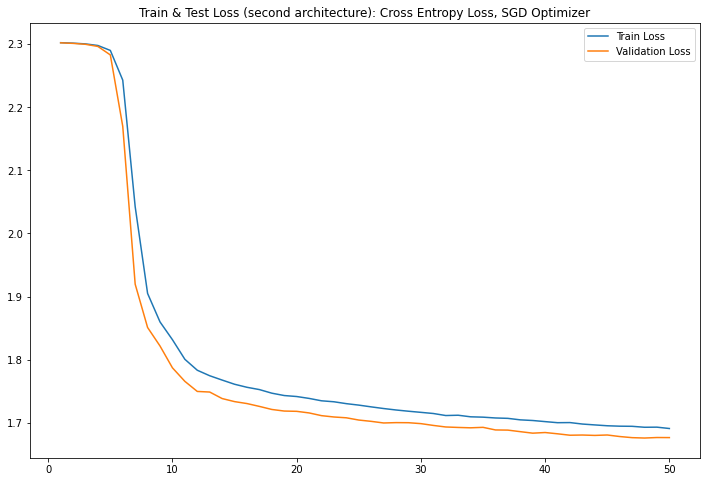

In [55]:
loss_plot(loss_train_list, loss_test_list,'second architecture','SGD Optimizer')

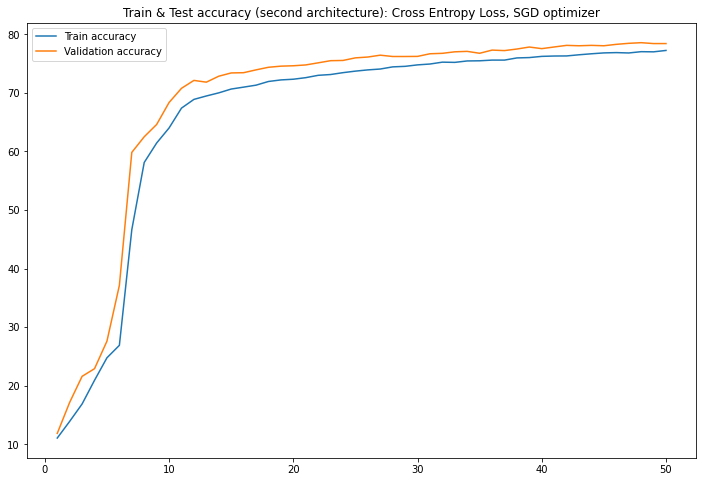

In [56]:
accuracy_plot(train_accuracy_list, test_accuracy_list,'second architecture', 'SGD optimizer')


#### Accuracy of each class:

In [57]:
# prepare to count predictions for each class
correct = {class_name: 0 for class_name in classes}
total = {class_name: 0 for class_name in classes}

# again no gradients needed
with torch.no_grad():
    for (inputs, labels) in test_loader:
        images, labels = inputs.to(device), labels.to(device)
        outputs = net_arc2(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions of each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct[classes[label]] += 1
            total[classes[label]] += 1


# print accuracy of each class
for class_name, correct_count in correct.items():
    accuracy = (float(correct_count)*100) / total[class_name]
    print(f'Accuracy of {class_name}: {accuracy:.2f} %')

Accuracy of T_shirt/Top: 88.70 %
Accuracy of Trouser: 95.90 %
Accuracy of Pullover: 85.80 %
Accuracy of Dress: 91.60 %
Accuracy of Coat: 86.70 %
Accuracy of Sandals: 93.80 %
Accuracy of Shirt: 0.00 %
Accuracy of Sneaker: 95.90 %
Accuracy of Bag: 97.10 %
Accuracy of Ankle boots: 94.50 %


#### Confusion Matrix

In [58]:
lst_pred = [predictions_list[i].tolist() for i in range(len(predictions_list))]
lst_lbl = [labels_list[i].tolist() for i in range(len(labels_list))]
lst_pred = list(chain.from_iterable(lst_pred))
lst_lbl = list(chain.from_iterable(lst_lbl))

confusion_matrix(lst_lbl, lst_pred)
print("Classification report:\n%s\n"
      % (metrics.classification_report(lst_lbl, lst_pred)))

c:\Users\Anni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Anni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70     60250
           1       0.87      0.85      0.86     60250
           2       0.57      0.56      0.56     62200
           3       0.66      0.79      0.72     58900
           4       0.50      0.75      0.60     59600
           5       0.71      0.80      0.75     59250
           6       0.00      0.00      0.00     59950
           7       0.56      0.83      0.67     60000
           8       0.91      0.79      0.85     60150
           9       0.88      0.84      0.86     59450

    accuracy                           0.69    600000
   macro avg       0.64      0.69      0.66    600000
weighted avg       0.64      0.69      0.66    600000




c:\Users\Anni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


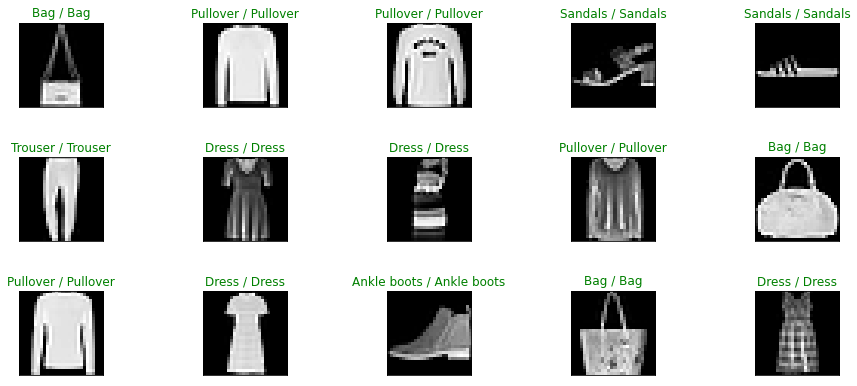

In [133]:
display_samples(net_arc3)

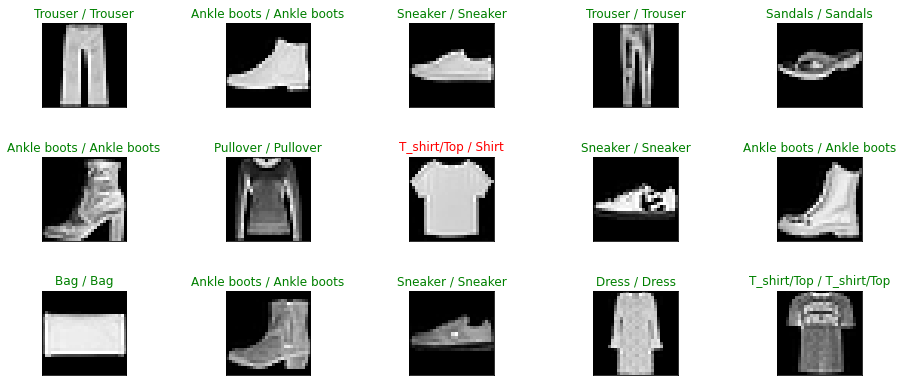

In [149]:
display_samples(net_arc3)